In [148]:
import findspark

In [149]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import  KMeans
from pyspark.sql import SQLContext
import pandas as pd
import glob
import yaml
import csv
import numpy as np

In [150]:
spark = SparkSession.builder.appName('player-clustering').getOrCreate()
df_bat = spark.read .format("csv").option("header", "true").load("BattingAveragesData.csv")
df_deb_bat = spark.read .format("csv").option("header", "true").load("DebutantBattingData.csv")

In [151]:
df_deb_bat = df_deb_bat.select('Player','Inns','Runs','HS','Ave','BF','SR')

In [152]:
df_bat.show(5)

+-----------+---+----+---+----+---+-----+---+------+---+---+---+---+---+--------------------+----+
|     Player|Mat|Inns| NO|Runs| HS|  Ave| BF|    SR|100| 50|  0| 4s| 6s|            TeamName|Year|
+-----------+---+----+---+----+---+-----+---+------+---+---+---+---+---+--------------------+----+
|   VR Aaron| 10|   3|  3|  35| 17|    0| 34|102.94|  0|  0|  0|  2|  1|Royal Challengers...|2014|
| MA Agarwal|  8|   8|  0| 115| 31|14.37| 91|126.37|  0|  0|  0| 12|  3|    Delhi Daredevils|2014|
|   AN Ahmed|  4|   1|  1|   4|  4|    0|  1|400.00|  0|  0|  0|  1|  0|Royal Challengers...|2014|
|CJ Anderson| 12|  11|  2| 265| 95|29.44|181|146.40|  0|  1|  0| 21| 15|      Mumbai Indians|2014|
| S Anirudha|  1|   1|  0|   3|  3| 3.00|  5| 60.00|  0|  0|  0|  0|  0| Sunrisers Hyderabad|2014|
+-----------+---+----+---+----+---+-----+---+------+---+---+---+---+---+--------------------+----+
only showing top 5 rows



In [153]:
df_deb_bat.show(5)

+--------------------+----+----+---+-----+---+------+
|              Player|Inns|Runs| HS|  Ave| BF|    SR|
+--------------------+----+----+---+-----+---+------+
|             PP Shaw|   9| 245| 65|27.22|160|153.12|
|             KM Asif|   1|   0|  0|    0|  0|     0|
|    Mujeeb Ur Rahman|  14|  51| 16|  8.5| 55| 92.72|
|JPR Scantlebury-S...|  31| 225| 29|10.71|210|107.14|
|     Abhishek Sharma|   3|  63| 46|   63| 33| 190.9|
+--------------------+----+----+---+-----+---+------+
only showing top 5 rows



In [154]:
df_bowl = spark.read .format("csv").option("header", "true").load("BowlingAveragesData.csv")
df_deb_bowl = spark.read .format("csv").option("header", "true").load("DebutantBowlingData.csv")

In [155]:
df_bowl.show(5)

+---------------+----+----+-----+----+----+----+----+-----+-----+----+---+---+---+---+----+
|         Player| Mat|Inns|Overs|Mdns|Runs|Wkts| BBI|  Ave| Econ|  SR|  4|  5| Ct| St|Year|
+---------------+----+----+-----+----+----+----+----+-----+-----+----+---+---+---+---+----+
|Abhishek Sharma| 3.0|   0|    0|   0|   0|   0|   0|    0|    0|   0|  0|  0|1.0|0.0|2018|
|        AD Nath| 1.0|   0|    0|   0|   0|   0|   0|    0|    0|   0|  0|  0|1.0|0.0|2018|
|     MA Agarwal|11.0|   0|    0|   0|   0|   0|   0|    0|    0|   0|  0|  0|2.0|0.0|2018|
|       KK Ahmed| 1.0| 1.0|  3.0| 0.0|38.0| 0.0|   0|    0|12.66|   0|0.0|0.0|0.0|0.0|2018|
|         MM Ali| 5.0| 5.0| 13.1| 0.0|97.0| 3.0|1/13|32.33| 7.36|26.3|0.0|0.0|2.0|0.0|2018|
+---------------+----+----+-----+----+----+----+----+-----+-----+----+---+---+---+---+----+
only showing top 5 rows



In [156]:
df_deb_bowl.show(5)

+--------------------+---+----+-----+----+----+-----+----+----+
|              Player|Mat|Inns|Balls|Runs|Wkts|  Ave|Econ|  SR|
+--------------------+---+----+-----+----+----+-----+----+----+
|             PP Shaw|  9|   0|    0|   0|   0|    0|   0|   0|
|             KM Asif|  4|   4|   84| 134|   8|16.75|9.57|10.5|
|    Mujeeb Ur Rahman| 46|  46| 1012|1166|  49|23.79|6.91|20.6|
|JPR Scantlebury-S...| 48|  29|  432| 625|  26|24.03|8.68|16.6|
|     Abhishek Sharma|  3|   0|    0|   0|   0|    0|   0|   0|
+--------------------+---+----+-----+----+----+-----+----+----+
only showing top 5 rows



In [157]:
df_deb_bowl = df_deb_bowl.select('Player','Inns','Runs','Wkts','Ave','Econ','SR')

In [158]:
df_deb_bowl.show(5)

+--------------------+----+----+----+-----+----+----+
|              Player|Inns|Runs|Wkts|  Ave|Econ|  SR|
+--------------------+----+----+----+-----+----+----+
|             PP Shaw|   0|   0|   0|    0|   0|   0|
|             KM Asif|   4| 134|   8|16.75|9.57|10.5|
|    Mujeeb Ur Rahman|  46|1166|  49|23.79|6.91|20.6|
|JPR Scantlebury-S...|  29| 625|  26|24.03|8.68|16.6|
|     Abhishek Sharma|   0|   0|   0|    0|   0|   0|
+--------------------+----+----+----+-----+----+----+
only showing top 5 rows



In [159]:
df_bat_new = df_bat.rdd.repartition(5).toDF()

In [160]:
df_bat_new.rdd.getNumPartitions()

5

In [161]:
df_bowl_new = df_bowl.rdd.repartition(5).toDF()
df_bowl_new.rdd.getNumPartitions()

5

In [162]:
df_bat_new.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Mat: string (nullable = true)
 |-- Inns: string (nullable = true)
 |-- NO: string (nullable = true)
 |-- Runs: string (nullable = true)
 |-- HS: string (nullable = true)
 |-- Ave: string (nullable = true)
 |-- BF: string (nullable = true)
 |-- SR: string (nullable = true)
 |-- 100: string (nullable = true)
 |-- 50: string (nullable = true)
 |-- 0: string (nullable = true)
 |-- 4s: string (nullable = true)
 |-- 6s: string (nullable = true)
 |-- TeamName: string (nullable = true)
 |-- Year: string (nullable = true)



In [163]:
df_bowl_new.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Mat: string (nullable = true)
 |-- Inns: string (nullable = true)
 |-- Overs: string (nullable = true)
 |-- Mdns: string (nullable = true)
 |-- Runs: string (nullable = true)
 |-- Wkts: string (nullable = true)
 |-- BBI: string (nullable = true)
 |-- Ave: string (nullable = true)
 |-- Econ: string (nullable = true)
 |-- SR: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- Ct: string (nullable = true)
 |-- St: string (nullable = true)
 |-- Year: string (nullable = true)



# lets append the debutant data with batsman data

In [164]:
data = df_bat_new.select('Player','Year','Inns','Runs','HS','Ave','BF','SR')

In [165]:
data=data[(data['Year']!='2018')].toPandas()

In [166]:
data=data.drop(['Year'], axis=1)

In [167]:
df_deb_bat_p = df_deb_bat.toPandas()
data = data.append(df_deb_bat_p)

In [168]:
data['Runs'] = data['Runs'].astype(float)

In [169]:
data['BF'] = data['BF'].astype(float)

In [170]:
data['Runs']=data['Runs']/data['BF']

In [171]:
data['Inns'] = data['Inns'].astype(int)
data['HS'] = data['HS'].astype(int)
data['SR'] = data['SR'].astype(float)
data['Ave'] = data['Ave'].astype(float)

In [172]:
data = data.groupby('Player',as_index=False).agg({'Inns':sum,'Runs':sum,'HS':max,'Ave': np.mean,'BF':sum,'SR': np.mean})

In [173]:
print(data)

                Player  Inns      Runs   HS        Ave      BF          SR
0       A Ashish Reddy     8  3.207646   32  23.915000    75.0  160.375000
1          A Choudhary     3  1.250000   15  25.000000    20.0  125.000000
2          A Dananjaya    19  0.820225   28   7.300000    89.0   82.020000
3             A Mishra    14  2.466117   13  14.750000    85.0   61.650000
4              A Nehra     8  1.142857    1   0.250000     8.0   28.570000
5              A Zampa     2  0.714286    5   2.500000     8.0   35.710000
6             AB Dinda     4  1.333333    7   2.750000    19.0   33.332500
7       AB de Villiers    52  6.350313  133  40.592500  1112.0  158.752500
8             AD Hales   190  1.422992  116  29.060000  3636.0  142.290000
9           AD Mathews    12  2.569801   31  18.285000   131.0  128.485000
10             AD Nath     4  0.740741   12   3.330000    28.0   37.035000
11          AD Russell    21  3.828117   66  21.356667   291.0  127.600000
12            AF Milne   

In [174]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [175]:
print(data.info)

<bound method DataFrame.info of                 Player  Inns      Runs   HS        Ave      BF          SR
0       A Ashish Reddy     8  3.207646   32  23.915000    75.0  160.375000
1          A Choudhary     3  1.250000   15  25.000000    20.0  125.000000
2          A Dananjaya    19  0.820225   28   7.300000    89.0   82.020000
3             A Mishra    14  2.466117   13  14.750000    85.0   61.650000
4              A Nehra     8  1.142857    1   0.250000     8.0   28.570000
5              A Zampa     2  0.714286    5   2.500000     8.0   35.710000
6             AB Dinda     4  1.333333    7   2.750000    19.0   33.332500
7       AB de Villiers    52  6.350313  133  40.592500  1112.0  158.752500
8             AD Hales   190  1.422992  116  29.060000  3636.0  142.290000
9           AD Mathews    12  2.569801   31  18.285000   131.0  128.485000
10             AD Nath     4  0.740741   12   3.330000    28.0   37.035000
11          AD Russell    21  3.828117   66  21.356667   291.0  127.

In [176]:
data_bowl = df_bowl_new.select('Player','Year','Inns','Runs','Wkts','Ave','Econ','SR') 
data_bowl = data_bowl[(data_bowl['Year']!='2018')] 
data_bowl = data_bowl[(data_bowl['Year']!='2018')].toPandas()
data_bowl = data_bowl.drop(['Year'], axis=1) 
df_deb_bowl_p = df_deb_bowl.toPandas()
data_bowl = data_bowl.append(df_deb_bowl_p)
data_bowl['Inns'] = data_bowl['Inns'].astype(float)
data_bowl['Runs'] = data_bowl['Runs'].astype(float)
data_bowl['Wkts'] = data_bowl['Wkts'].astype(float)
data_bowl['Ave'] = data_bowl['Ave'].astype(float)
data_bowl['Econ'] = data_bowl['Econ'].astype(float)
data_bowl['SR'] = data_bowl['SR'].astype(float)
data_bowl['Runs'] = data_bowl['Runs']/data_bowl['Inns']
data_bowl['Wkts'] = data_bowl['Wkts']/data_bowl['Inns']
data_bowl = data_bowl.groupby('Player', as_index=False).agg({'Inns':sum,'Runs':sum,'Econ':np.mean,'Ave': np.mean,'SR': np.mean,'Wkts':sum})

print(data_bowl) 
print(type(data_bowl))

                Player  Inns        Runs       Econ        Ave         SR  \
0       A Ashish Reddy   6.0   32.000000   9.250000  27.830000  17.500000   
1          A Choudhary   5.0   28.800000   8.550000  28.800000  20.200000   
2          A Dananjaya  51.0   25.725490   7.220000  23.420000  19.400000   
3             A Mishra  50.0  108.904762   8.267500  35.942500  25.825000   
4              A Nehra  34.0  121.270833   8.412500  21.220000  15.300000   
5              A Zampa  11.0   50.166667   7.485000  16.430000  12.750000   
6             AB Dinda  23.0  126.333333  10.142500  48.500000  28.450000   
7       AB de Villiers   0.0    0.000000   0.000000   0.000000   0.000000   
8             AD Hales   2.0    3.500000  14.000000   0.000000   0.000000   
9           AD Mathews  12.0   52.600000   9.700000  17.570000  12.850000   
10             AD Nath   0.0    0.000000   0.000000   0.000000   0.000000   
11          AD Russell  27.0   75.173077   8.776667  31.513333  20.666667   

In [177]:
from pyspark.sql.types import *

print(data.dtypes)
mySchema = StructType([StructField("Player", StringType(), True), StructField("Inns", IntegerType(), True), StructField("Runs", FloatType(), True), StructField("HS", IntegerType(), True), StructField("Ave", FloatType(), True), StructField("BF", FloatType(), True), StructField("SR", FloatType(), True)])
data = spark.createDataFrame(data,schema=mySchema)
features=['Inns','Runs','HS','Ave','BF','SR']
for c in data.columns:
    if c in features:
        data= data.withColumn(c,data[c].cast('float'))
data.show()

Player     object
Inns        int64
Runs      float64
HS          int64
Ave       float64
BF        float64
SR        float64
dtype: object
+--------------+-----+----------+-----+---------+------+--------+
|        Player| Inns|      Runs|   HS|      Ave|    BF|      SR|
+--------------+-----+----------+-----+---------+------+--------+
|A Ashish Reddy|  8.0| 3.2076461| 32.0|   23.915|  75.0| 160.375|
|   A Choudhary|  3.0|      1.25| 15.0|     25.0|  20.0|   125.0|
|   A Dananjaya| 19.0| 0.8202247| 28.0|      7.3|  89.0|   82.02|
|      A Mishra| 14.0| 2.4661171| 13.0|    14.75|  85.0|   61.65|
|       A Nehra|  8.0| 1.1428572|  1.0|     0.25|   8.0|   28.57|
|       A Zampa|  2.0|0.71428573|  5.0|      2.5|   8.0|   35.71|
|      AB Dinda|  4.0| 1.3333334|  7.0|     2.75|  19.0| 33.3325|
|AB de Villiers| 52.0| 6.3503127|133.0|  40.5925|1112.0|158.7525|
|      AD Hales|190.0| 1.4229923|116.0|    29.06|3636.0|  142.29|
|    AD Mathews| 12.0| 2.5698006| 31.0|   18.285| 131.0| 128.485|
| 

In [178]:
print(data_bowl.dtypes)
myBowlSchema = StructType([StructField("Player", StringType(), True), StructField("SR", FloatType(), True), StructField("Wkts", FloatType(), True), StructField("Econ", FloatType(), True), StructField("Inns", FloatType(), True), StructField("Runs", FloatType(), True), StructField("Ave", FloatType(), True)])
data_bowl = spark.createDataFrame(data_bowl,schema=myBowlSchema)

features_ball=['Inns','Runs','Wkts','Ave','Econ','SR']
for c in data_bowl.columns:
    if c in features_ball:
        data_bowl= data_bowl.withColumn(c,data_bowl[c].cast('float'))
data_bowl.show()

Player     object
Inns      float64
Runs      float64
Econ      float64
Ave       float64
SR        float64
Wkts      float64
dtype: object
+--------------+----+----------+--------+---------+---------+---------+
|        Player|  SR|      Wkts|    Econ|     Inns|     Runs|      Ave|
+--------------+----+----------+--------+---------+---------+---------+
|A Ashish Reddy| 6.0|      32.0|    9.25|    27.83|     17.5|     1.25|
|   A Choudhary| 5.0|      28.8|    8.55|     28.8|     20.2|      1.0|
|   A Dananjaya|51.0|  25.72549|    7.22|    23.42|     19.4|1.0980393|
|      A Mishra|50.0| 108.90476|  8.2675|  35.9425|   25.825|3.0928571|
|       A Nehra|34.0|121.270836|  8.4125|    21.22|     15.3|5.8333335|
|       A Zampa|11.0| 50.166668|   7.485|    16.43|    12.75|3.5666666|
|      AB Dinda|23.0|126.333336| 10.1425|     48.5|    28.45|2.1111112|
|AB de Villiers| 0.0|       0.0|     0.0|      0.0|      0.0|      0.0|
|      AD Hales| 2.0|       3.5|    14.0|      0.0|      0.0|      0

In [179]:
features=['Runs','HS','Ave','BF','SR']
vec = VectorAssembler(inputCols=features, outputCol="features")
df_bat_clus = vec.transform(data).select('Player','features')
df_bat_clus.show(5)

+--------------+--------------------+
|        Player|            features|
+--------------+--------------------+
|A Ashish Reddy|[3.20764613151550...|
|   A Choudhary|[1.25,15.0,25.0,2...|
|   A Dananjaya|[0.82022470235824...|
|      A Mishra|[2.46611714363098...|
|       A Nehra|[1.14285719394683...|
+--------------+--------------------+
only showing top 5 rows



In [180]:
features_ball=['Runs','Wkts','Ave','Econ','SR']
vec_ball = VectorAssembler(inputCols=features_ball, outputCol="features_ball")
df_ball_clus = vec_ball.transform(data_bowl).select('Player','features_ball')
df_ball_clus.show()

+--------------+--------------------+
|        Player|       features_ball|
+--------------+--------------------+
|A Ashish Reddy|[17.5,32.0,1.25,9...|
|   A Choudhary|[20.2000007629394...|
|   A Dananjaya|[19.3999996185302...|
|      A Mishra|[25.8250007629394...|
|       A Nehra|[15.3000001907348...|
|       A Zampa|[12.75,50.1666679...|
|      AB Dinda|[28.4500007629394...|
|AB de Villiers|           (5,[],[])|
|      AD Hales|[0.0,3.5,0.0,14.0...|
|    AD Mathews|[12.8500003814697...|
|       AD Nath|           (5,[],[])|
|    AD Russell|[20.6666660308837...|
|      AF Milne|[26.0,76.5,1.75,1...|
|      AJ Finch|           (5,[],[])|
|        AJ Tye|[10.5,23.5,2.0,6....|
|      AM Nayar|           (5,[],[])|
|     AM Rahane|           (5,[],[])|
|      AN Ahmed|[50.2999992370605...|
|       AP Tare|           (5,[],[])|
|      AR Bawne|           (5,[],[])|
+--------------+--------------------+
only showing top 20 rows



In [181]:
error = np.zeros(15)
for k in range(2,15):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_bat_clus.sample(False,0.25, seed=1))
    error[k] = model.computeCost(df_bat_clus) 

In [182]:
errorBowl = np.zeros(15)
for k in range(2,15):
    kmeans_ball = KMeans().setK(k).setSeed(1).setFeaturesCol("features_ball")
    model_ball = kmeans_ball.fit(df_ball_clus.sample(False,0.25, seed=1))
    errorBowl[k] = model_ball.computeCost(df_ball_clus)

[       0.                0.         41857359.74339804 11370377.03201301
  7069016.3911489   3460158.36387041  2643884.32925348  2288409.19786205
  1965506.22073869  1615081.36619433  1494146.89543021  1350889.43868891
  1169300.42572418  1005513.99321381   878340.03289843]


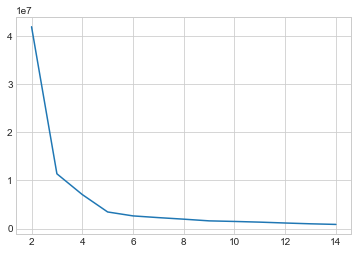

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

ax.plot(range(2,15),error[2:15])
print(error)

[     0.              0.         270726.31187917 209472.33379253
 141311.98263485 116228.71932185  75997.24174308  70662.06013074
  59233.0904738   48970.93767417  47050.10523075  46878.37932801
  37061.73402526  42802.334503    42798.67084163]


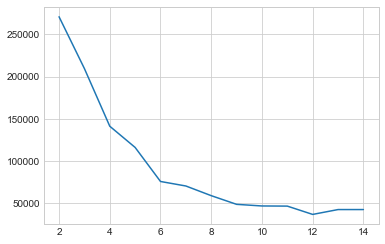

In [184]:
plt.style.use('seaborn-whitegrid')
fig_bowl = plt.figure()
ax_bowl = plt.axes()

ax_bowl.plot(range(2,15),errorBowl[2:15])
print(errorBowl)

In [185]:
k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_bat_clus)
centers = model.clusterCenters()

print("Centers: ")
for i in range(len(centers)):
    print(i+1,": ",centers[i])

Centers: 
1 :  [ 1.53070586 16.76        8.74507085 39.685      80.53724171]
2 :  [  4.70636603  90.17647059  30.67723022 967.11764706 130.57048977]
3 :  [   2.8031128   118.83333333   34.54083347 2144.83333333  140.58416748]
4 :  [  3.41573001  69.02        23.97846657 360.14       129.26141678]


In [186]:
k = 5
kmeans_ball = KMeans().setK(k).setSeed(1).setFeaturesCol("features_ball")
model_ball = kmeans_ball.fit(df_ball_clus)
centers_ball = model_ball.clusterCenters()

print("Centers: ")
for i in range(len(centers_ball)):
    print(i+1,": ",centers_ball[i])

Centers: 
1 :  [24.30606056 63.98546829  1.81156256  8.84480302 15.87272727]
2 :  [0.07446809 1.58510638 0.01595745 1.01958333 0.24468085]
3 :  [ 23.22333338 108.80508287   3.39117235   8.63044443  34.24444444]
4 :  [ 18.97999992  25.93037338   1.06053593   7.84000015 122.2       ]
5 :  [23.0851648  28.76062888  0.83621652  8.49619962 10.05494505]


In [187]:
bat_preds = model.transform(df_bat_clus).select('Player','features','prediction')
bat_r = bat_preds.collect()
bat = pd.DataFrame(bat_r)
bat.columns = ['Player', 'Features', 'Cluster']
bat.head()

Player                                           Features  Cluster
0  A Ashish Reddy  [3.207646131515503, 32.0, 23.915000915527344, ...        0
1     A Choudhary                    [1.25, 15.0, 25.0, 20.0, 125.0]        0
2     A Dananjaya  [0.8202247023582458, 28.0, 7.300000190734863, ...        0
3        A Mishra  [2.4661171436309814, 13.0, 14.75, 85.0, 61.650...        0
4         A Nehra  [1.1428571939468384, 1.0, 0.25, 8.0, 28.569999...        0

In [188]:
ball_preds = model_ball.transform(df_ball_clus).select('Player','features_ball','prediction')
ball_r = ball_preds.collect()
ball = pd.DataFrame(ball_r)
ball.columns = ['Player', 'Features', 'Cluster']
ball.head()

Player                                           Features  Cluster
0  A Ashish Reddy                      [17.5, 32.0, 1.25, 9.25, 6.0]        4
1     A Choudhary  [20.200000762939453, 28.799999237060547, 1.0, ...        4
2     A Dananjaya  [19.399999618530273, 25.72549057006836, 1.0980...        4
3        A Mishra  [25.825000762939453, 108.9047622680664, 3.0928...        2
4         A Nehra  [15.300000190734863, 121.27083587646484, 5.833...        2

In [189]:
bat.groupby(['Cluster']).size()

Cluster
0    200
1     34
2      6
3     50
dtype: int64

In [190]:
ball.groupby(['Cluster']).size()

Cluster
0    55
1    94
2    45
3     5
4    91
dtype: int64

# lets play with ball by ball data now

In [192]:
df_delivery = spark.read .format("csv").option("header", "true").load("delivery_data.csv")

In [193]:
#lets do a rdd partition
ipl_5 = df_delivery.rdd.repartition(5).toDF()
ipl_5.rdd.getNumPartitions()
ipl_5.printSchema()

root
 |-- batsman: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs_by_batsman: string (nullable = true)
 |-- wicket: string (nullable = true)
 |-- same_player_out: string (nullable = true)
 |-- extra: string (nullable = true)



In [194]:
ipl_data = ipl_5.select('batsman','bowler','runs_by_batsman','wicket','same_player_out','extra')
ipl_data.show()
type(ipl_data)

+----------+---------+---------------+------+---------------+-----+
|   batsman|   bowler|runs_by_batsman|wicket|same_player_out|extra|
+----------+---------+---------------+------+---------------+-----+
| MK Pandey|IK Pathan|              0|  null|           null| null|
| MK Pandey|IK Pathan|              6|  null|           null| null|
| MK Pandey|IK Pathan|              0|  null|           null| True|
| MK Pandey| S Nadeem|              1|  null|           null| null|
|  AJ Finch| S Nadeem|              0|  null|           null| null|
|  AJ Finch| S Nadeem|              2|  null|           null| null|
|  AJ Finch| S Nadeem|              1|  null|           null| null|
| MK Pandey| S Nadeem|              1|  null|           null| null|
|  AJ Finch| S Nadeem|              1|  null|           null| null|
|  AJ Finch| UT Yadav|              6|  null|           null| null|
| LJ Wright| S Nadeem|              1|  null|           null| null|
|AD Mathews| S Nadeem|              1|  null|   

pyspark.sql.dataframe.DataFrame

In [195]:
ipl_pd = ipl_data.toPandas()
ipl_pd.head()

ipl_pd = ipl_pd.drop(['same_player_out','extra'], axis=1)
ipl_pd.columns = ['batsman','bowler','runs','wicket']
ipl_pd.head()

batsman     bowler runs wicket
0  MK Pandey  IK Pathan    0   None
1  MK Pandey  IK Pathan    6   None
2  MK Pandey  IK Pathan    0   None
3  MK Pandey   S Nadeem    1   None
4   AJ Finch   S Nadeem    0   None

In [196]:
ipl_group = ipl_pd.groupby(['batsman','bowler'])
summary = ipl_group.agg({'runs':lambda x:(x==0).count()})
summary.head()

runs
batsman        bowler             
A Ashish Reddy A Nehra           9
               AB Dinda          7
               AD Mathews       12
               AD Russell        3
               Anureet Singh     2

In [197]:
ipl_group2 = ipl_pd.groupby(['batsman','bowler'])
x0 = ipl_group2['runs'].apply(lambda x: x[x == 0].count()).to_frame().reset_index()
x1 = ipl_group2['runs'].apply(lambda x: x[x == 1].count()).to_frame().reset_index()
x2 = ipl_group2['runs'].apply(lambda x: x[x == 2].count()).to_frame().reset_index()
x3 = ipl_group2['runs'].apply(lambda x: x[x == 3].count()).to_frame().reset_index()
x4 = ipl_group2['runs'].apply(lambda x: x[x == 4].count()).to_frame().reset_index()
x6 = ipl_group2['runs'].apply(lambda x: x[x == 6].count()).to_frame().reset_index()
xw = ipl_group2['wicket'].apply(lambda x: x[x == True].count()).to_frame().reset_index()
xb = ipl_group2['runs'].apply(lambda x: x.count()).to_frame().reset_index()

In [198]:
from functools import reduce
dfs = [x0,x1,x2,x3,x4,x6,xw,xb]
new_df = reduce(lambda left,right: pd.merge(left,right, how='inner', on=['batsman','bowler']), dfs)
new_df.columns = ['batsman','bowler','0','1','2','3','4','6','wickets','balls']
print(new_df)

              batsman            bowler  0  1  2  3  4  6  wickets  balls
0      A Ashish Reddy           A Nehra  0  0  0  0  0  0        0      9
1      A Ashish Reddy          AB Dinda  0  0  0  0  0  0        0      7
2      A Ashish Reddy        AD Mathews  0  0  0  0  0  0        0     12
3      A Ashish Reddy        AD Russell  0  0  0  0  0  0        0      3
4      A Ashish Reddy     Anureet Singh  0  0  0  0  0  0        0      2
5      A Ashish Reddy     Azhar Mahmood  0  0  0  0  0  0        0      3
6      A Ashish Reddy           B Kumar  0  0  0  0  0  0        0      1
7      A Ashish Reddy     BW Hilfenhaus  0  0  0  0  0  0        0      2
8      A Ashish Reddy         CH Morris  0  0  0  0  0  0        0      5
9      A Ashish Reddy          DJ Bravo  0  0  0  0  0  0        0     13
10     A Ashish Reddy   Harbhajan Singh  0  0  0  0  0  0        0      8
11     A Ashish Reddy       Imran Tahir  0  0  0  0  0  0        0      2
12     A Ashish Reddy           J Both

In [200]:
def thresholdfilter(threshold):
    df_sub = new_df[new_df['balls']>threshold]
    df_sub['0'] = (df_sub['0']+1)/(df_sub['balls']+6)
    df_sub['1'] = (df_sub['1']+1)/(df_sub['balls']+6)
    df_sub['2'] = (df_sub['2']+1)/(df_sub['balls']+6)
    df_sub['3'] = (df_sub['3']+1)/(df_sub['balls']+6)
    df_sub['4'] = (df_sub['4']+1)/(df_sub['balls']+6)
    df_sub['6'] = (df_sub['6']+1)/(df_sub['balls']+6)
    df_sub['wickets'] = 1-((df_sub['wickets']+1)/(df_sub['balls']+1))
    l = [df_sub['0'], df_sub['1'], df_sub['2'], df_sub['3'], df_sub['4'], df_sub['6'], df_sub['wickets']]
    for i in range(len(l)-2):
        l[i+1] = l[i]+l[i+1]
        df_sub[df_sub.columns[i+3]]=l[i+1]
    return df_sub
      
filtered=thresholdfilter(9)
print(filtered)
df_fallprobs = [[np.mean(filtered['0']),np.mean(filtered['1']),np.mean(filtered['2']),np.mean(filtered['3']),np.mean(filtered['4']),np.mean(filtered['6'])]]
df_wicketprob = np.mean(filtered['wickets'])*1.05

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

              batsman           bowler         0         1         2  \
2      A Ashish Reddy       AD Mathews  0.055556  0.111111  0.166667   
9      A Ashish Reddy         DJ Bravo  0.052632  0.105263  0.157895   
31     A Ashish Reddy    R Vinay Kumar  0.058824  0.117647  0.176471   
42     A Ashish Reddy         UT Yadav  0.062500  0.125000  0.187500   
53           A Chopra       PJ Sangwan  0.062500  0.125000  0.187500   
108          A Mishra         AB Dinda  0.047619  0.095238  0.142857   
124          A Mishra  Harbhajan Singh  0.052632  0.105263  0.157895   
134          A Mishra        JO Holder  0.062500  0.125000  0.187500   
137          A Mishra       KA Pollard  0.062500  0.125000  0.187500   
139          A Mishra        KV Sharma  0.062500  0.125000  0.187500   
142          A Mishra         L Balaji  0.050000  0.100000  0.150000   
144          A Mishra         M Morkel  0.058824  0.117647  0.176471   
148          A Mishra         MM Patel  0.043478  0.086957  0.13

In [201]:
def clusterprob(batsman,bowler,random):
    if((len(bat[bat['Player']==batsman])>0) and (len(ball[ball['Player']==bowler])>0)):
        
        batClus = bat[bat['Player']==batsman].iloc[0]['Cluster']
        ballClus = ball[ball['Player']==bowler].iloc[0]['Cluster']
        
        #each batsman of this cluster ka probability with that bowler
        batsmenInClus = bat[bat['Cluster']==batClus].loc[:]["Player"]
        bowlersInClus = ball[ball['Cluster']==ballClus].loc[:]["Player"]
        
        #print("Batsman Cluster Size",len(batsmenInClus))
        #print("Bowler Cluster Size",len(bowlersInClus))
        
        df=[]
        wicketProbs=[]
        for aBatsman in batsmenInClus:
            df_sub = filtered[(filtered['batsman']==aBatsman) & (filtered['bowler']==bowler)]
            if len(df_sub)>0:
                l = [df_sub['0'].iloc[0], df_sub['1'].iloc[0], df_sub['2'].iloc[0], df_sub['3'].iloc[0], df_sub['4'].iloc[0], df_sub['6'].iloc[0]]
                df.append(l)
                wicketProbs.append(df_sub['wickets'].iloc[0])
        for aBowler in bowlersInClus:
            df_sub = filtered[(filtered['batsman']==batsman) & (filtered['bowler']==aBowler)]
            if len(df_sub)>0:
                l = [df_sub['0'].iloc[0], df_sub['1'].iloc[0], df_sub['2'].iloc[0], df_sub['3'].iloc[0], df_sub['4'].iloc[0], df_sub['6'].iloc[0]]
                df.append(l)
                wicketProbs.append(df_sub['wickets'].iloc[0])
        if(df==[]):
            #print("hello",batsman,bowler)
            df=df_fallprobs 
            wicketProbs=df_wicketprob
        df=pd.DataFrame(df)
        runList=['0','1','2','3','4','6']
        df.columns=runList
        meanProb=df.mean()
        wicketProb=np.mean(wicketProbs)
        index=0
        for i in range(len(meanProb)):
            if (meanProb[i]<random):
                index=i+1
        return [int(runList[index%6]),wicketProb]
    else:
        df=df_fallprobs
        wicketProbs=df_wicketprob
        df=pd.DataFrame(df)
        runList=['0','1','2','3','4','6']
        df.columns=runList
        meanProb=df.mean()
        wicketProb=np.mean(wicketProbs)
        index=0
        for i in range(len(meanProb)):
            if (meanProb[i]<random):
                index=i+1
        return [int(runList[index]),wicketProb]
clusterprob("V Kohli","AD Mathews", 0.946)            
            
        
    

[0, 0.949476302207979]

In [222]:
def pvpprob(batsman,bowler,random):
    df_sub = filtered[(filtered['batsman']==batsman) & (filtered['bowler']==bowler)]
    if len(df_sub)>0:
        #print(df_sub)
        #print(df_sub)
        l = [df_sub['0'], df_sub['1'], df_sub['2'], df_sub['3'], df_sub['4'], df_sub['6']]
        res = [0,1,2,3,4,6]
        index=0
        for i in range(len(l)):
            if (l[i].iloc[0]<random):
                index=i+1
            #print(int(res[index]),df_sub['wickets'])
        #return [int(res[index]),df_sub['wickets'].iloc[0]]
        return clusterprob(batsman,bowler,random)
    else:
        return clusterprob(batsman,bowler,random)

In [223]:
pvpprob("V Kohli","A Ashish Reddy",0.94215)

[0, 0.9530436915385012]

In [219]:
pvpprob("RG Sharma","Washington Sundar",0.50)

[0, 0.940628275993609]

In [209]:
import random
from copy import deepcopy
def matchSimulation(t1bat,t1bowl,t2bat,t2bowl):
    innings=2
    overs=20
    ballsPerOver=6
    runs=[0,0]
    wickets=[0,0]
    batting=[t1bat,t2bat]
    bowling=[t2bowl,t1bowl]
    bbbrec=[]
    p=0
    batsmenPlaying={'strike':{'name':batting[0][0], 'wicketProb': 1}, 'nonStrike':{'name':batting[0][1],'wicketProb': 1}}
    #print(batsmenPlaying)
    for i in range(innings):
        for j in range(overs):
            #random.seed(10)
            for k in range(ballsPerOver):  
                #print(j, " : ",p)
                p+=1
                randomvar = random.uniform(0, 1)
                #if j<6 or j>15:
                #    randomvar=random.uniform(0.2, 1)
                pvpRes=pvpprob(batsmenPlaying['strike']['name'],bowling[i][j%len(bowling[i])],randomvar)
                batsmenPlaying['strike']['wicketProb']*=pvpRes[1]
                if(batsmenPlaying['strike']['wicketProb']>0.3):
                    runs[i]+=pvpRes[0]
                    bbbrec.append(pvpRes[0])
                    if(pvpRes[0]%2==1):
                        temp=batsmenPlaying['nonStrike']
                        batsmenPlaying['nonStrike']=batsmenPlaying['strike']
                        batsmenPlaying['strike']=temp
                else:
                    wickets[i]+=1
                    bbbrec.append(deepcopy(batsmenPlaying['strike']['name']))
                    if(wickets[i]>=10):
                        break;
                    batsmenPlaying['strike']['name']=batting[i][wickets[i]+1]
                    batsmenPlaying['strike']['wicketProb']=1
                    
                if (runs[1]>runs[0]):
                    break
                
            else:
                temp=batsmenPlaying['nonStrike']
                batsmenPlaying['nonStrike']=batsmenPlaying['strike']
                batsmenPlaying['strike']=temp
                #print(bbbrec)
                continue
            break
    print(bbbrec)
    print("Number of balls: ",len(bbbrec))
    #winTeam= runs[0]<runs[1]?runs[1]:runs[0]
    print("Team 1: ",runs[0],"/",wickets[0],"\tTeam 2: ",runs[1],"/",wickets[1],sep="")
    if(runs[0]<runs[1]):
        winTeam = "Team 2"
    else:
        winTeam = "Team 1"
    return winTeam


In [224]:
t1bat=['LMP Simmons','PA Patel','AT Rayudu','RG Sharma','KH Pandya','KA Pollard','HH Pandya','KV Sharma','MG Johnson','JJ Bumrah','SL Malinga']
t2bowl=['JD Unadkat','Washington Sundar','JD Unadkat','Washington Sundar','JD Unadkat','DT Christian','SN Thakur','DT Christian','A Zampa','LH Ferguson','A Zampa','LH Ferguson','A Zampa','Washington Sundar','A Zampa','Washington Sundar','DT Christian','SN Thakur','JD Unadkat','DT Christian']

t2bat=['AM Rahane','RA Tripathi','SPD Smith','MS Dhoni','MK Tiwary','DT Christian','Washington Sundar','LH Ferguson','A Zampa','SN Thakur','JD Unadkat']
t1bowl=['KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma']

matchSimulation(t1bat,t1bowl,t2bat,t2bowl)

[0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 'LMP Simmons', 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 'PA Patel', 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'AT Rayudu', 0, 0, 0, 0, 3, 0, 3, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 'RG Sharma', 2, 0, 0, 1, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 'KH Pandya', 0, 0, 0, 0, 2, 0, 'KA Pollard', 0, 0, 0, 4, 0, 0, 0, 0, 4, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 'HH Pandya', 0, 0, 3, 0, 1, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 'SPD Smith', 0, 0, 0, 0, 0, 6, 4, 6, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 'MS Dhoni', 0, 0, 0, 0, 'MK Tiwary', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 'Washington Sundar', 0, 0]
Number of balls:  240
Team 1: 65/5	Team 2: 65/6


'Team 1'

In [225]:
match3={
"team2_bowling_order":["DL Chahar","L Ngidi","DL Chahar","L Ngidi","SN Thakur","DL Chahar","DJ Bravo","RA Jadeja","DJ Bravo","RA Jadeja","DL Chahar","RA Jadeja","SN Thakur","RA Jadeja","DJ Bravo","L Ngidi","DJ Bravo","SN Thakur","L Ngidi","SN Thakur"],
"team1_bowling_order":["B Kumar","Sandeep Sharma","B Kumar","S Kaul","B Kumar","S Kaul","CR Brathwaite","Rashid Khan","CR Brathwaite","Rashid Khan","Shakib Al Hasan","Rashid Khan","Sandeep Sharma","Shakib Al Hasan","Sandeep Sharma","Rashid Khan","S Kaul","CR Brathwaite","S Kaul","B Kumar"],
"team1_batting_order":["S Dhawan","SP Goswami","KS Williamson","MK Pandey","Shakib Al Hasan","YK Pathan","CR Brathwaite","B Kumar","Rashid Khan","S Kaul","Sandeep Sharma"],
"team2_batting_order":["SR Watson","F du Plessis","SK Raina","AT Rayudu","MS Dhoni","DJ Bravo","RA Jadeja","DL Chahar","Harbhajan Singh","SN Thakur","L Ngidi"]
}

In [226]:
matchSimulation(match3["team2_batting_order"],match3["team2_bowling_order"],match3["team1_batting_order"],match3["team1_bowling_order"])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'SR Watson', 0, 0, 0, 0, 4, 6, 'F du Plessis', 0, 6, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'SK Raina', 0, 0, 2, 0, 6, 1, 0, 0, 'AT Rayudu', 2, 6, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 'DJ Bravo', 'MS Dhoni', 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 'KS Williamson', 0, 0, 0, 'MK Pandey', 0, 1, 0, 0, 6, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, 'Shakib Al Hasan', 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 'YK Pathan', 1, 3, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0]
Number of balls:  240
Team 1: 80/4	Team 2: 77/6


'Team 1'

# now i will try to use decision tree to generate the scores

In [227]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

In [228]:
bat_clus = spark.read .format("csv").option("header", "true").load("Batting_Clusters.csv")
bowl_clus = spark.read .format("csv").option("header", "true").load("Bowling_Clusters.csv")
over_data = spark.read.format("csv").option("header","true").load("Over_Data.csv")

In [229]:
over_data.head()
Bowl_Clus = bowl_clus.toPandas()
Bat_Clus = bat_clus.toPandas()
Bowl_Clus.fillna(0)
Bat_Clus.fillna(0)
Bat_Clus.head()
Bowl_Clus.head()

Player Name     Runs/Wickets          Economy Balls bowled/wickets  \
0  A Ashish Reddy               22  9.2093023255814      14.333333333333   
1      A Chandila               22  6.2051282051282      21.272727272727   
2     A Choudhary             28.8  8.7272727272727                 19.8   
3      A Flintoff             52.5  9.5454545454545                   33   
4        A Kumble  23.511111111111  6.5919003115265                 21.4   

    wickets/innings  
0               0.9  
1  0.91666666666667  
2                 1  
3  0.66666666666667  
4   1.0714285714286

In [230]:
Bat_Clus.head()

Player Name Runs/Innings  Strike Rate Innings/(innings-notouts)  \
0  A Ashish Reddy  12.17391304  145.0777202               1.533333333   
1      A Chandila            2  57.14285714                         0   
2        A Chopra  8.833333333  74.64788732                         1   
3     A Choudhary  8.333333333          125                         3   
4      A Flintoff  20.66666667  116.9811321                       1.5   

      Sixes/BF     Fours/BF  
0   0.07253886  0.088082902  
1            0            0  
2            0  0.098591549  
3         0.05         0.05  
4  0.037735849  0.094339623

In [231]:
Bowl_Clus.head()

Player Name     Runs/Wickets          Economy Balls bowled/wickets  \
0  A Ashish Reddy               22  9.2093023255814      14.333333333333   
1      A Chandila               22  6.2051282051282      21.272727272727   
2     A Choudhary             28.8  8.7272727272727                 19.8   
3      A Flintoff             52.5  9.5454545454545                   33   
4        A Kumble  23.511111111111  6.5919003115265                 21.4   

    wickets/innings  
0               0.9  
1  0.91666666666667  
2                 1  
3  0.66666666666667  
4   1.0714285714286

In [232]:
over_data.head()

Row(Over='0.0', Batsman='RV Uthappa', NonStriker='AJ Finch', Bowler='IK Pathan', TotalRuns='11.0', TotalWickets='0.0', BBattingAverage='26.41958042', BBattingStrikeRate='131.63763070000002', BSixProb='0.043554007', BFourProb='0.131358885', BowlingAverage='33.1125', Economy='7.8026509572900995', BowlingStrikeRate='25.4625', WicketsProb='0.79207920792079', NBattingAverage='25.046875', NBattingStrikeRate='130.4312449', NSixProb='0.048006509', NFourProb='0.138323841')

In [233]:
Over_Data = over_data.toPandas()

In [234]:
Over_Data.head()

Over     Batsman NonStriker     Bowler TotalRuns TotalWickets  \
0  0.0  RV Uthappa   AJ Finch  IK Pathan      11.0          0.0   
1  0.0  RV Uthappa   AJ Finch  IK Pathan       0.0          0.0   
2  6.0  RV Uthappa   AJ Finch  IK Pathan      15.0          0.0   
3  1.0  RV Uthappa   AJ Finch   M Morkel       5.0          0.0   
4  3.0  RV Uthappa   AJ Finch   M Morkel       7.0          0.0   

  BBattingAverage  BBattingStrikeRate     BSixProb    BFourProb  \
0     26.41958042  131.63763070000002  0.043554007  0.131358885   
1     26.41958042  131.63763070000002  0.043554007  0.131358885   
2     26.41958042  131.63763070000002  0.043554007  0.131358885   
3     26.41958042  131.63763070000002  0.043554007  0.131358885   
4     26.41958042  131.63763070000002  0.043554007  0.131358885   

   BowlingAverage             Economy BowlingStrikeRate       WicketsProb  \
0         33.1125  7.8026509572900995           25.4625  0.79207920792079   
1         33.1125  7.8026509572900995           25.4625  0.79207920792079   
2         33.1125  7.8026509572900995           25.4625  0.79207920792079   
3  27.12987012987  7.6999631404349005    21.14025974026               1.1   
4  27.12987012987  7.6999631404349005    21.14025974026               1.1   

  NBattingAverage NBattingStrikeRate     NSixProb    NFourProb  
0       25.046875        130.4312449  0.048006509  0.138323841  
1       25.046875        130.4312449  0.048006509  0.138323841  
2       25.046875        130.4312449  0.048006509  0.138323841  
3       25.046875        130.4312449  0.048006509  0.138323841  
4       25.046875        130.4312449  0.048006509  0.138323841

In [235]:
Over_df = over_data.rdd.repartition(5).toDF()
Over_df.fillna(0)
Over_df=Over_df.drop('Batsman')
Over_df=Over_df.drop('Bowler')
Over_df=Over_df.drop('NonStriker')
Over_R = Over_df.drop('TotalWickets')
Over_W = Over_df.drop('TotalRuns')
Over_W = Over_W.rdd
Over_R = Over_R.rdd
print(type(Over_W))

<class 'pyspark.rdd.RDD'>


In [236]:
def flatten(aList):
    t = []
    for i in aList:
        if not isinstance(i, list):
             t.append(i)
        else:
             t.extend(flatten(i))
    return t

def train_create(vec):
    res = vec[1]
    
    feat = []
    feat.append(vec[0])
    feat = feat + list(vec[2:])
    feat = flatten(feat)
    return LabeledPoint(res,feat)

wicketData = Over_W.map(train_create)
runsData = Over_R.map(train_create)

print(wicketData)

PythonRDD[2079] at RDD at PythonRDD.scala:53


In [237]:
def getBatsmanStat(name):
    player = Bat_Clus[Bat_Clus['Player Name']==name]
    if(player.empty):
        l = np.array(Bat_Clus.mean())
    else:
        player.drop('Player Name', axis=1, inplace=True)
        l = np.array(player.values[0])
    return l
        
def getBowlerStat(name):
    player = Bowl_Clus[Bowl_Clus['Player Name']==name]
    if(player.empty):
        l = np.array(Bowl_Clus.mean())
    else:
        player.drop('Player Name', axis=1, inplace=True)
        l = np.array(player.values[0])
    return l

#getBowlerStat('DJ Bravo')
getBatsmanStat('DJ Bravo')

/Users/ammarpathan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array(['15.20481928', '126.3263263', '1.509090909', '0.048048048',
       '0.103103103'], dtype=object)

In [238]:
wicketModel = DecisionTree.trainRegressor(wicketData, impurity='variance',categoricalFeaturesInfo={}, maxDepth=30, maxBins=40)
print(wicketModel.toDebugString())

DecisionTreeModel regressor of depth 30 with 13465 nodes
  If (feature 0 <= 16.5)
   If (feature 0 <= 12.5)
    If (feature 7 <= 24.095238095238)
     If (feature 1 <= 15.708333334999999)
      If (feature 7 <= 16.042857142857)
       If (feature 11 <= 0.06486676)
        If (feature 11 <= 0.0203176565)
         If (feature 6 <= 7.2412989309541)
          If (feature 1 <= 14.033333335)
           Predict: 0.0
          Else (feature 1 > 14.033333335)
           Predict: 1.0
         Else (feature 6 > 7.2412989309541)
          If (feature 0 <= 0.5)
           Predict: 0.0
          Else (feature 0 > 0.5)
           If (feature 4 <= 0.0740904515)
            If (feature 3 <= 0.06012962350000001)
             Predict: 0.0
            Else (feature 3 > 0.06012962350000001)
             Predict: 1.0
           Else (feature 4 > 0.0740904515)
            If (feature 0 <= 5.5)
             If (feature 0 <= 1.5)
              Predict: 1.0
             Else (feature 0 > 1.5)
              Pred

In [239]:
runsModel = DecisionTree.trainRegressor(runsData, impurity='variance',categoricalFeaturesInfo={}, maxDepth=30, maxBins=40)
print(runsModel.toDebugString())

DecisionTreeModel regressor of depth 30 with 38379 nodes
  If (feature 0 <= 13.5)
   If (feature 6 <= 8.415706008540699)
    If (feature 0 <= 1.5)
     If (feature 2 <= 124.304317)
      If (feature 0 <= 0.5)
       If (feature 3 <= 0.059114936)
        If (feature 8 <= 0.43303571428571497)
         If (feature 10 <= 138.42809365)
          If (feature 8 <= 0.32795698924731)
           If (feature 3 <= 0.0237390815)
            Predict: 2.0
           Else (feature 3 > 0.0237390815)
            If (feature 2 <= 122.9504019)
             If (feature 1 <= 13.27011494)
              Predict: 7.0
             Else (feature 1 > 13.27011494)
              If (feature 1 <= 20.78104974)
               Predict: 5.0
              Else (feature 1 > 20.78104974)
               Predict: 6.0
            Else (feature 2 > 122.9504019)
             Predict: 2.0
          Else (feature 8 > 0.32795698924731)
           If (feature 5 <= 32.803763440859996)
            If (feature 9 <= 21.299999999999997)

In [240]:
import random
random.seed(20)

def matchSimulation(inn1Ba,inn1Bo,inn2Ba,inn2Bo):
    batting=[inn1Ba,inn2Ba]
    bowling=[inn2Bo,inn1Bo]
    match=[[],[]]
    runPerInn=[0,0]
    wicketCount=[0,0]
    strike={}
    offStrike={}
    bowler={}    
    for inn in range(2):
        strike['name']=batting[inn][0]
        offStrike['name']=batting[inn][1]
        
        for over in range(20):
            bowler['name']=bowling[inn][over%len(bowling[inn])]
            strike['data']= getBatsmanStat(strike['name'])
            offStrike['data']=getBatsmanStat(offStrike['name'])
            bowler['data']=getBowlerStat(bowler['name'])
            overData=[over]
            overData.extend(strike['data'])
            overData.extend(offStrike['data'])
            overData.extend(bowler['data'])
            
            runs=round(runsModel.predict(overData)*(random.uniform(1,1.2)))
            wickets=round(wicketModel.predict(overData)*(random.uniform(1,1.25)))
            match[inn].append([strike['name'],offStrike['name'],bowler['name'],runs,wickets])
            if(wickets):
                runs=round((runs/6)*(6-wickets))
                if((wicketCount[inn]+wickets)>=10):
                    wicketCount[inn]=10
                    runPerInn[inn]+=runs
                    match[inn].append([strike['name'],offStrike['name'],runs,'all out']) 
                    break;
                wicketCount[inn]+=wickets  
                strike['name']=batting[inn][wicketCount[inn]+1]
                
            runPerInn[inn]+=runs
            if(runPerInn[1]>runPerInn[0]):
                break
            strike,offStrike= offStrike,strike
    for i in match[0]:
        print(i)
    print('\n\n')
    for i in match[1]:
        print(i)
    print("\n1st Innings: ",runPerInn[0],"/",wicketCount[0])
    print("\n2nd Innings: ",runPerInn[1],"/",wicketCount[1])

In [241]:
t1bat=['LMP Simmons','PA Patel','AT Rayudu','RG Sharma','KH Pandya','KA Pollard','HH Pandya','KV Sharma','MG Johnson','JJ Bumrah','SL Malinga']
t2bowl=['JD Unadkat','Washington Sundar','JD Unadkat','Washington Sundar','JD Unadkat','DT Christian','SN Thakur','DT Christian','A Zampa','LH Ferguson','A Zampa','LH Ferguson','A Zampa','Washington Sundar','A Zampa','Washington Sundar','DT Christian','SN Thakur','JD Unadkat','DT Christian']

t2bat=['AM Rahane','RA Tripathi','SPD Smith','MS Dhoni','MK Tiwary','DT Christian','Washington Sundar','LH Ferguson','A Zampa','SN Thakur','JD Unadkat']
t1bowl=['KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma','KH Pandya','MG Johnson','JJ Bumrah','SL Malinga','KV Sharma']

matchSimulation(t1bat, t1bowl, t2bat, t2bowl)

['LMP Simmons', 'PA Patel', 'JD Unadkat', 4, 0]
['PA Patel', 'LMP Simmons', 'Washington Sundar', 10, 0]
['LMP Simmons', 'PA Patel', 'JD Unadkat', 9, 0]
['PA Patel', 'LMP Simmons', 'Washington Sundar', 8, 0]
['LMP Simmons', 'PA Patel', 'JD Unadkat', 8, 0]
['PA Patel', 'LMP Simmons', 'DT Christian', 8, 0]
['LMP Simmons', 'PA Patel', 'SN Thakur', 7, 0]
['PA Patel', 'LMP Simmons', 'DT Christian', 8, 0]
['LMP Simmons', 'PA Patel', 'A Zampa', 7, 0]
['PA Patel', 'LMP Simmons', 'LH Ferguson', 8, 0]
['LMP Simmons', 'PA Patel', 'A Zampa', 8, 0]
['PA Patel', 'LMP Simmons', 'LH Ferguson', 8, 0]
['LMP Simmons', 'PA Patel', 'A Zampa', 7, 0]
['PA Patel', 'LMP Simmons', 'Washington Sundar', 7, 1]
['LMP Simmons', 'AT Rayudu', 'A Zampa', 31, 1]
['AT Rayudu', 'RG Sharma', 'Washington Sundar', 5, 1]
['RG Sharma', 'KH Pandya', 'DT Christian', 14, 1]
['KH Pandya', 'KA Pollard', 'SN Thakur', 9, 0]
['KA Pollard', 'KH Pandya', 'JD Unadkat', 16, 0]
['KH Pandya', 'KA Pollard', 'DT Christian', 13, 1]



['AM Raha

In [242]:
match1={
"team1_batting_order":["SR Watson","AT Rayudu","SK Raina","SW Billings","RA Jadeja","MS Dhoni","DJ Bravo","Harbhajan Singh","DL Chahar","SN Thakur","Imran Tahir"],
"team2_batting_order":["AS Yadav","SR Tendulkar","Ishan Kishan","RG Sharma","JP Duminy","KH Pandya","HH Pandya","BCJ Cutting","MJ McClenaghan","SL Malinga","JJ Bumrah"],
"team1_bowling_order":["DL Chahar","SN Thakur","DL Chahar","SR Watson","DL Chahar","SN Thakur","SR Watson","Harbhajan Singh","Imran Tahir","Harbhajan Singh","Imran Tahir","Harbhajan Singh","DJ Bravo","SR Watson","DJ Bravo","SN Thakur","DJ Bravo","SR Watson","SN Thakur","Imran Tahir"],
"team2_bowling_order":["MJ McClenaghan","JJ Bumrah","MJ McClenaghan","HH Pandya","KH Pandya","HH Pandya","KH Pandya","SL Malinga","BCJ Cutting","SL Malinga","MJ McClenaghan","KH Pandya","JJ Bumrah","KH Pandya","HH Pandya","SL Malinga","JJ Bumrah","MJ McClenaghan","JJ Bumrah","HH Pandya"]
}


In [243]:
matchSimulation(match1["team1_batting_order"],match1["team1_bowling_order"],match1["team2_batting_order"],match1["team2_bowling_order"])

['SR Watson', 'AT Rayudu', 'MJ McClenaghan', 3, 0]
['AT Rayudu', 'SR Watson', 'JJ Bumrah', 10, 0]
['SR Watson', 'AT Rayudu', 'MJ McClenaghan', 9, 0]
['AT Rayudu', 'SR Watson', 'HH Pandya', 7, 0]
['SR Watson', 'AT Rayudu', 'KH Pandya', 7, 0]
['AT Rayudu', 'SR Watson', 'HH Pandya', 8, 0]
['SR Watson', 'AT Rayudu', 'KH Pandya', 7, 0]
['AT Rayudu', 'SR Watson', 'SL Malinga', 7, 0]
['SR Watson', 'AT Rayudu', 'BCJ Cutting', 8, 0]
['AT Rayudu', 'SR Watson', 'SL Malinga', 7, 0]
['SR Watson', 'AT Rayudu', 'MJ McClenaghan', 7, 0]
['AT Rayudu', 'SR Watson', 'KH Pandya', 8, 0]
['SR Watson', 'AT Rayudu', 'JJ Bumrah', 8, 0]
['AT Rayudu', 'SR Watson', 'KH Pandya', 7, 1]
['SR Watson', 'SK Raina', 'HH Pandya', 23, 1]
['SK Raina', 'SW Billings', 'SL Malinga', 8, 1]
['SW Billings', 'RA Jadeja', 'JJ Bumrah', 2, 1]
['RA Jadeja', 'MS Dhoni', 'MJ McClenaghan', 36, 0]
['MS Dhoni', 'RA Jadeja', 'JJ Bumrah', 9, 0]
['RA Jadeja', 'MS Dhoni', 'HH Pandya', 24, 2]



['AS Yadav', 'SR Tendulkar', 'DL Chahar', 3, 2]
[